<a href="https://colab.research.google.com/github/isabelesb/Analise_RFM_Clusterizacao/blob/main/RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotecas e base de dados:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from yellowbrick.cluster import kelbow_visualizer

import warnings

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DNC/DNC - Desafios/data.csv', encoding='unicode_escape')

##Análises Iniciais:

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
data.duplicated().sum()

5268

In [ ]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


##Conclusões:
1. Há dados faltantes em CustomerID e em Description.
2. As datas não estão no formato certo.
3. Há valores duplicados.
4. Há valores negativos em Quantity e UnitPrice.
5. Provavelmente há outliers em Quantity e em Price.

##Tratamento dos dados:

In [ ]:
# Retirando os dados faltantes de CostumerID e verificando.
data = data.dropna(subset=['CustomerID'])
data['CustomerID'].isna().sum()

0

In [ ]:
# Removendo dados com quantidade errada
data = data.query('Quantity > 0')

In [ ]:
# Removendo dados com preço errado
data = data.query('UnitPrice > 0')

In [ ]:
# Removendo duplicatas e verificando
data = data.drop_duplicates()
data.duplicated().sum()

0

In [ ]:
# Corrigindo o tipo de dado da data
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [ ]:
# Corrigindo o tipo de dado do CustomerID
data['CustomerID'] = data['CustomerID'].astype(int)

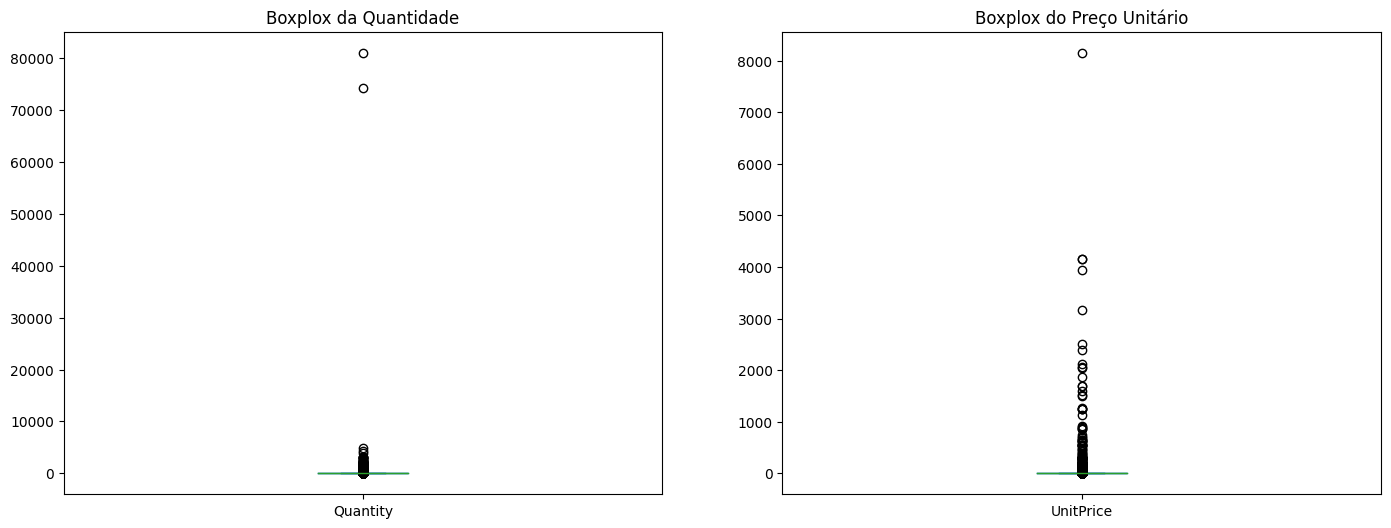

In [ ]:
# Analisando melhor os outliers
fig, axes = plt.subplots(ncols = 2, figsize = (17,6))

data['Quantity'].plot.box(ax=axes[0], title = 'Boxplox da Quantidade')
data['UnitPrice'].plot.box(ax=axes[1], title = 'Boxplox do Preço Unitário')

plt.show()

In [ ]:
# Corrigindo Quantity e UnitPrice
data = data.query('Quantity <= 10000')
data = data.query('UnitPrice <= 5000')

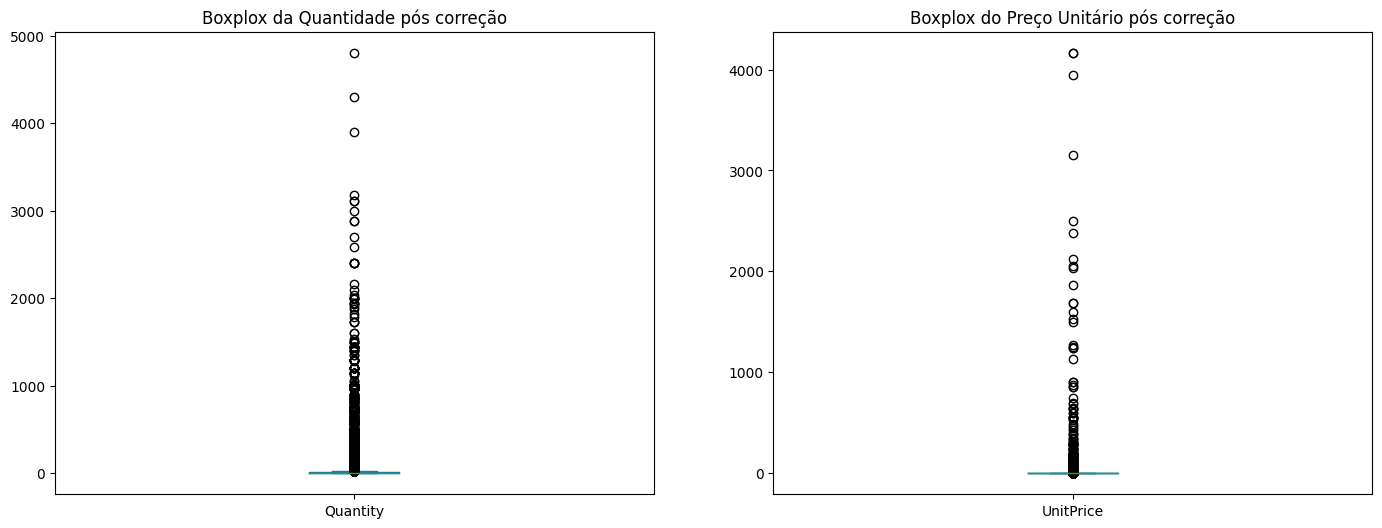

In [ ]:
# Verificando as correções anteriores
fig, axes = plt.subplots(ncols = 2, figsize = (17,6))

data['Quantity'].plot.box(ax=axes[0], title = 'Boxplox da Quantidade pós correção')
data['UnitPrice'].plot.box(ax=axes[1], title = 'Boxplox do Preço Unitário pós correção')

plt.show()

In [ ]:
# Criando coluna do preço total e verificando
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [ ]:
# Criando a variável de última data
last_date = max(data['InvoiceDate'].dt.date)
last_date

datetime.date(2011, 12, 9)

##Visualizações:

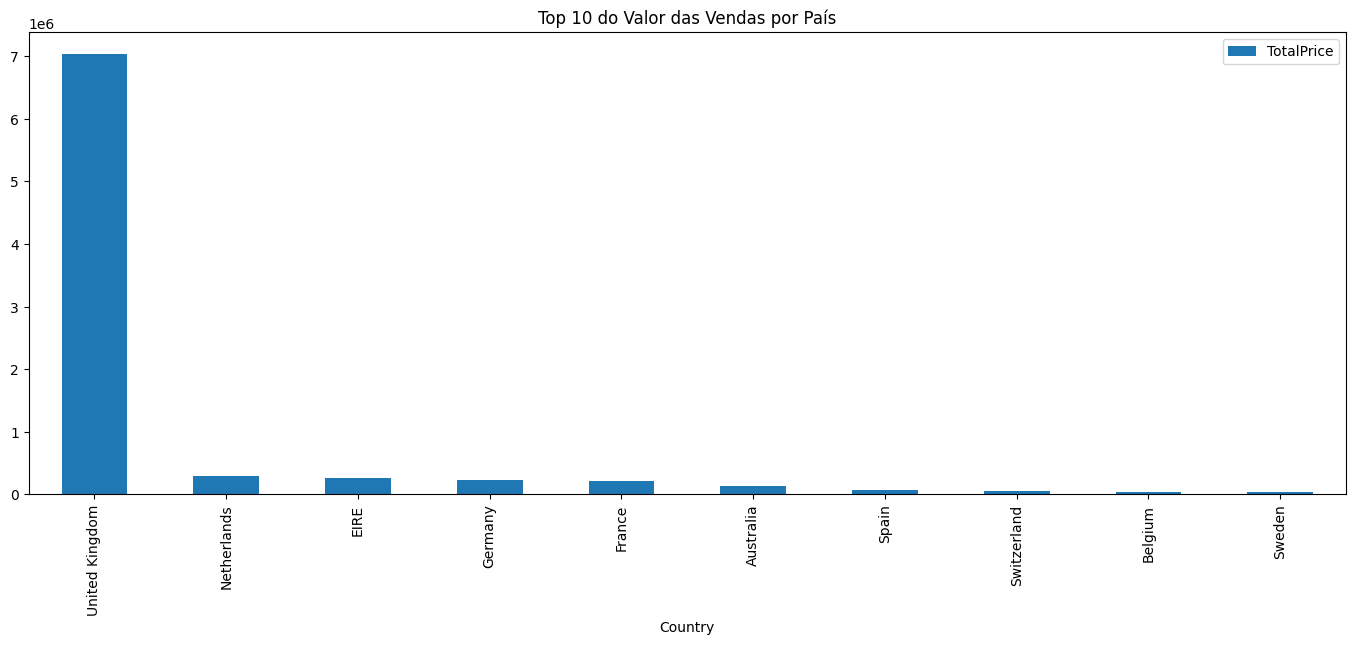

In [ ]:
# Top 10 valor total das vendas por País
sales = pd.DataFrame(data.groupby(['Country'])['TotalPrice'].sum()).sort_values(by='TotalPrice', ascending = False).head(10)
sales.plot.bar(figsize=(17,6), title = 'Top 10 do Valor das Vendas por País');

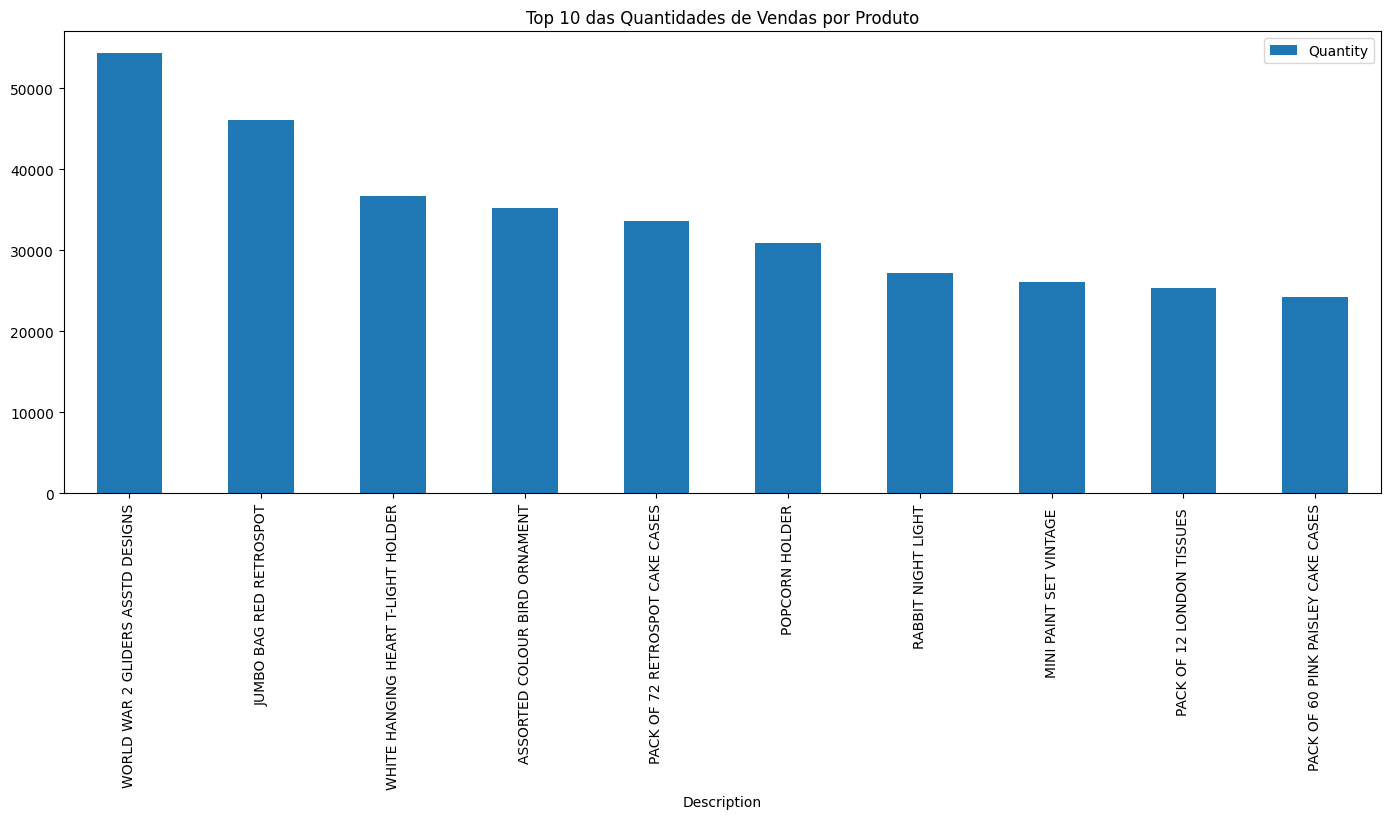

In [ ]:
# Top 10 quantidade de vendas por Produto
prod = pd.DataFrame(data.groupby(['Description'])['Quantity'].sum()).sort_values(by='Quantity', ascending = False).head(10)
prod.plot.bar(figsize=(17,6), title = 'Top 10 das Quantidades de Vendas por Produto');

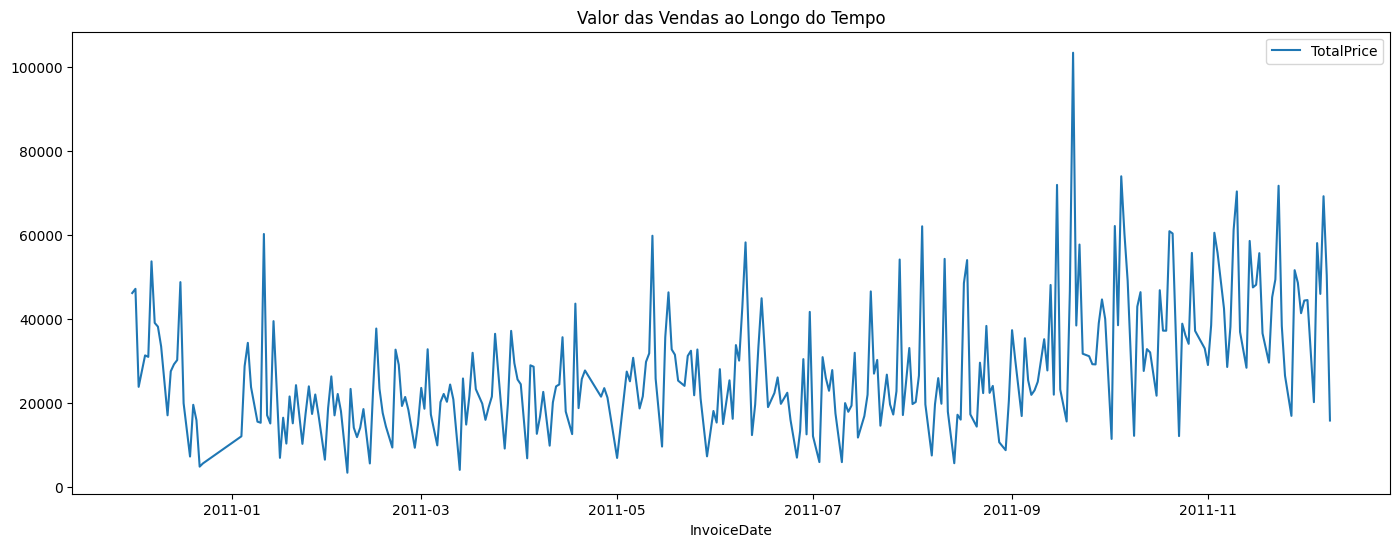

In [ ]:
# Vendas ao longo do tempo
sales_date = pd.DataFrame(data.groupby(data['InvoiceDate'].dt.date)['TotalPrice'].sum())
sales_date.plot.line(figsize=(17,6), title = 'Valor das Vendas ao Longo do Tempo');

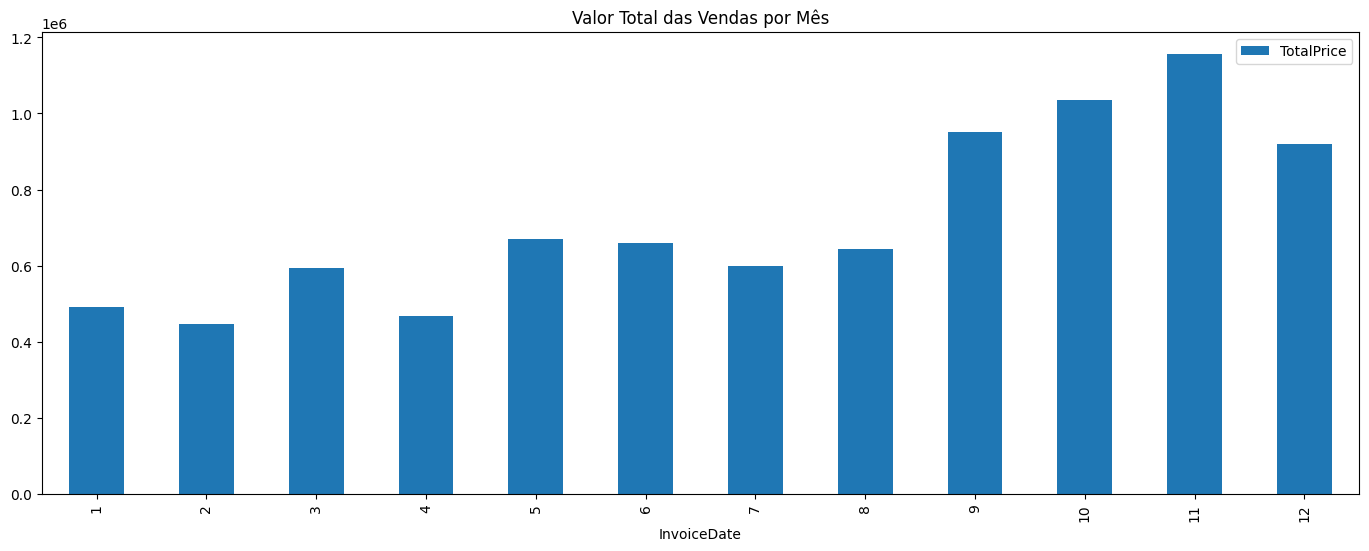

In [ ]:
# Vendas por mês
sales_month = pd.DataFrame(data.groupby(data['InvoiceDate'].dt.month)['TotalPrice'].sum())
sales_month.plot.bar(figsize = (17,6), title = 'Valor Total das Vendas por Mês');

In [ ]:
# Valor vendido por Mês, por País.
sales_month_country = data[['InvoiceDate', 'Country', 'TotalPrice']]
sales_month_country['InvoiceDate'] = sales_month_country['InvoiceDate'].dt.month
sales_month_country = sales_month_country.groupby(['InvoiceDate', 'Country'])[['TotalPrice']].sum().sort_values(by=['TotalPrice', 'InvoiceDate'], ascending = False).reset_index().head(15)

sales_month_country
#sales_month_country.plot.bar(figsize= (17,5), title= 'Valor vendido por mês por país', rot=0)
#.plot(figsize= (17,5), title= 'Valor vendido por mês por país', hue= 'Country')
px.bar(data_frame=sales_month_country, x='InvoiceDate', y='TotalPrice', color='Country', barmode="group", title='Valor vendido por mês por país - top 15')

<ipython-input-28-d7445475eb4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_month_country['InvoiceDate'] = sales_month_country['InvoiceDate'].dt.month


##RFM:


In [ ]:
# Construção da tabela rfm
referencia_data = pd.to_datetime('01/01/2012')

df_rfm = data.groupby('CustomerID').agg(
    R = ('InvoiceDate', lambda x: (referencia_data - max(x)).days),
    F = ('InvoiceNo', 'nunique'),
    M = ('TotalPrice', 'mean')
)
df_rfm.head()

,R,F,M
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824


<Axes: >

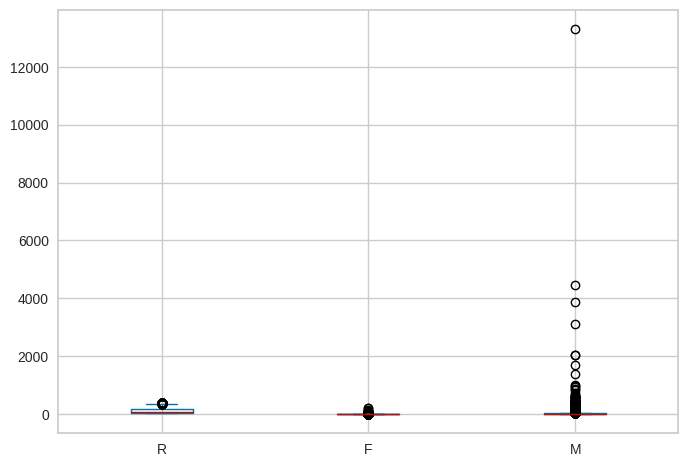

In [ ]:
# Visualizando a tabela
df_rfm.plot.box()

<Axes: >

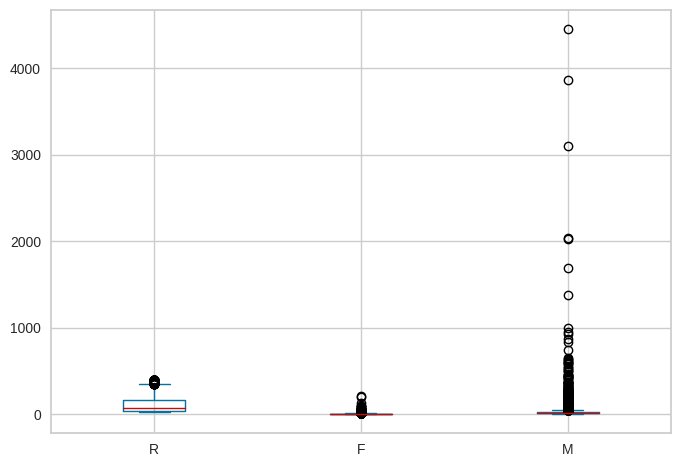

In [ ]:
# Retirando o outlier mais descrepante.
df_rfm = df_rfm.query('M<8000')
df_rfm.plot.box()

<Axes: >

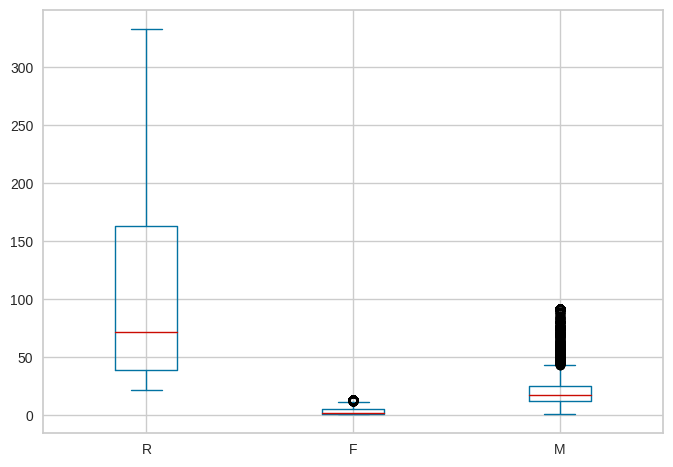

In [ ]:
# Estipulando um limite máximo, de forma que os valores acima sejam modificados para ele.
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.plot.box()

<Axes: >

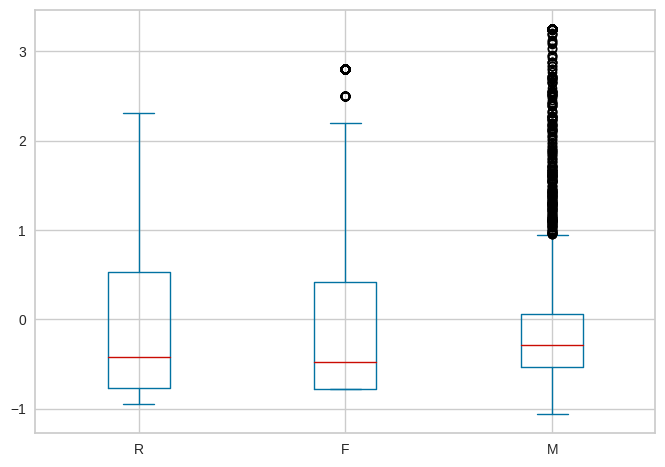

In [ ]:
# Normalizando:
df_rfm_clip_norm = df_rfm_clip.apply(scale)
df_rfm_clip_norm.plot.box()

## Clusterização:
Vamos testar diferentes tipos de clusterização, escolhendo a que melhor descreve e separa os dados. Utilizaremos K-Means, DBSCAN, Clusterização Hierárquica e Mean Shift nas comparações.

In [ ]:
X = df_rfm_clip_norm.copy()

### K-Means:

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

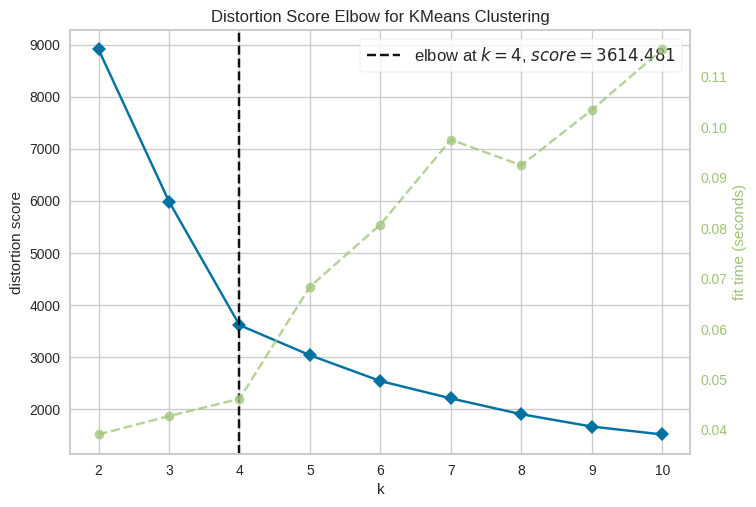

In [ ]:
# Utilizando o método do cotovelo para escolher o melhor número de clusters.
kelbow_visualizer(KMeans(), df_rfm_clip_norm, k=10);

In [ ]:
# Plotando o resultado:
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(df_rfm_clip_norm)
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str))

### DBSCAN:

In [ ]:
# Plotando o resultado do modelo:
dbscan = DBSCAN()
dbscan_labels = dbscan.fit_predict(X)
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=dbscan_labels.astype(str))

### Clusterização Hierárquica:

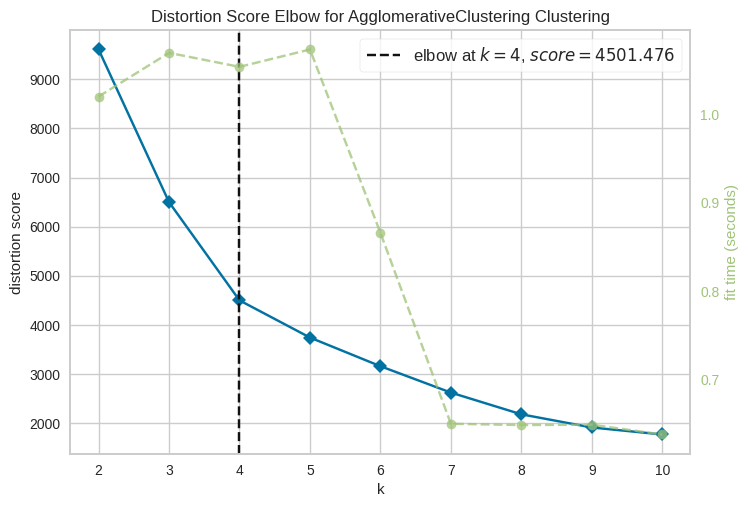

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10))

In [ ]:
# Utilizando o método do cotovelo para escolher o melhor número de clusters:
kelbow_visualizer(AgglomerativeClustering(), df_rfm_clip_norm, k=10)

In [ ]:
# Plotando o resultado:
hcluster = AgglomerativeClustering(4)
hcluster_labels = hcluster.fit_predict(df_rfm_clip_norm)
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=hcluster_labels.astype(str))

### Mean Shift:

In [ ]:
# Plotando o resultado do modelo
mshift = MeanShift()
mshift_labels = mshift.fit_predict(X)
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=mshift_labels.astype(str))

### Comparação entre os clusters, pelas métricas:

In [ ]:
print(11*'-'+'K-Means'+11*'-')
print(f'Silhouette = {silhouette_score(df_rfm_clip_norm, kmeans_labels):.3f}')
print(f'Davies Bouldin = {davies_bouldin_score(df_rfm_clip_norm, kmeans_labels):.3f}')
print(f'Calinski Harabasz = {calinski_harabasz_score(df_rfm_clip_norm, kmeans_labels):.3f}')

print(11*'-'+'DBSCAN'+12*'-')
print(f'Silhouette = {silhouette_score(df_rfm_clip_norm, dbscan_labels):.3f}')
print(f'Davies Bouldin = {davies_bouldin_score(df_rfm_clip_norm, dbscan_labels):.3f}')
print(f'Calinski Harabasz = {calinski_harabasz_score(df_rfm_clip_norm, dbscan_labels):.3f}')

print(2*'-'+'Clusterização Hierárquica'+2*'-')
print(f'Silhouette = {silhouette_score(df_rfm_clip_norm, hcluster_labels):.3f}')
print(f'Davies Bouldin = {davies_bouldin_score(df_rfm_clip_norm, hcluster_labels):.3f}')
print(f'Calinski Harabasz = {calinski_harabasz_score(df_rfm_clip_norm, hcluster_labels):.3f}')

print(9*'-'+'Mean Shift'+10*'-')
print(f'Silhouette = {silhouette_score(df_rfm_clip_norm, mshift_labels):.3f}')
print(f'Davies Bouldin = {davies_bouldin_score(df_rfm_clip_norm, mshift_labels):.3f}')
print(f'Calinski Harabasz = {calinski_harabasz_score(df_rfm_clip_norm, mshift_labels):.3f}')

-----------K-Means-----------
Silhouette = 0.480
Davies Bouldin = 0.704
Calinski Harabasz = 3752.749
-----------DBSCAN------------
Silhouette = 0.331
Davies Bouldin = 1.443
Calinski Harabasz = 42.792
--Clusterização Hierárquica--
Silhouette = 0.401
Davies Bouldin = 0.829
Calinski Harabasz = 2728.754
---------Mean Shift----------
Silhouette = 0.421
Davies Bouldin = 0.911
Calinski Harabasz = 1174.981


Percebemos aqui que o K-Means é a melhor opção, de acordo com as métrias e os gráficos.

## Análise dos Clusters:

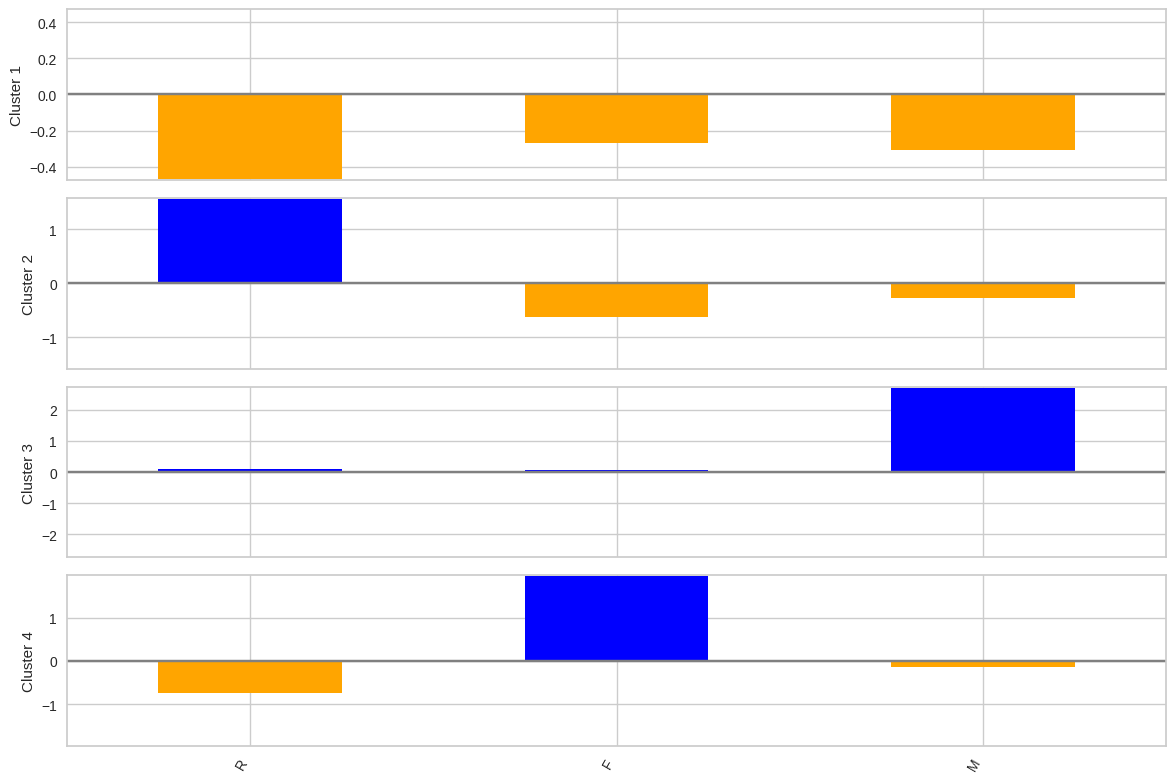

In [ ]:
# Plotando os clusters:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip.columns)

fig,axes = plt.subplots(nrows=4, figsize=(12,8), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['blue' if l > 0 else 'orange' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

Percebemos que: \
* No Cluster 1, temos os menores índices, ou seja, clientes que compraram há pouquíssimo tempo, mas em pouca quantidade, e gastando pouco. Esses podem ser os novos clientes. \
* No Cluster 2, temos a recência mais alta e frequência e ticket médio baixos. Esses podem ser clientes churn, ou que tenham comprado poucas vezes. \
* O terceiro grupo, tem baixa recência, a maior frequência e um ticket médio baixo. Podem ser clientes que fazem pequenas compras recorrentes. \
* Por fim, o Último grupo tem recência e freqência razoáveis e o maior ticket médio. Podem ser clientes que fazem grandes compras ou compram produtos mais caros, mas poucas vezes. \

Vale lembrar que estamos analisando dados em janeiro, então a recência pode estar sendo influenciada pelas festas de fim de ano, principalmente no primeiro grupo.

A partir dessas análises é possívem pensar em campanhas de marketing personalizadas. Uma boa opção é analisar quais são os ítens mais vendidos em cada cluster, com o objetivo de liquidar os menos comprados e oferecer sugestões personalizadas que envolvam os outros.